# Имплементация Super Resolutional GAN из [данной статьи](https://arxiv.org/pdf/1609.04802.pdf)

In [34]:
import os

import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from tqdm.notebook import tqdm
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as tt
from torchvision.models import mobilenet_v2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Dataset и Dataloader
#### Dataset взят с [kaggle](https://www.kaggle.com/saputrahas/dataset-image-super-resolution)

In [2]:
!gdown https://drive.google.com/uc?id=10dSB56jd5Dze_eCn9V6gxa04g_3ovVyE -O data.zip
!unzip data.zip > /dev/null

Downloading...
From: https://drive.google.com/uc?id=10dSB56jd5Dze_eCn9V6gxa04g_3ovVyE
To: /content/data.zip
2.25GB [00:46, 48.7MB/s]


In [3]:
class SuperImage(Dataset):
    def __init__(self, dir, transform=None, transforms_large=None, transforms_small=None):
        self.files = self.__check_image(dir)
        self.dir = dir
        self.transforms = transform
        self.transforms_large = transforms_large
        self.transforms_small = transforms_small
    
    def __getitem__(self, ind):
        image_path = os.path.join(self.dir, self.files[ind])
        image = Image.open(image_path).convert('RGB')
        if self.transforms:
            image = self.transforms(image)
        small_image = image.copy()
        if self.transforms_large:
            image = self.transforms_large(image)
        if self.transforms_small:
            small_image = self.transforms_small(small_image)        
        return image, small_image

    def __check_image(self, dir):
        path_images = os.listdir(dir)
        result = []
        for path_image in tqdm(path_images):
            im = cv2.imread(os.path.join(dir, path_image))
            if im.shape == (720, 1024, 3):
                result.append(path_image)
        return result

    def __len__(self):
        return len(self.files)

In [4]:
mean, std = 0.5, 0.5
transform_image = tt.Compose(
    [
     tt.Resize(270),
     tt.RandomCrop((224, 224))
    ]
)
transform_large_img = tt.Compose(
    [
     tt.ToTensor(),
     tt.Normalize(mean, std)
    ]
)
transform_small_img = tt.Compose(
    [
     tt.Resize(56),
     tt.ToTensor(),
     tt.Normalize(mean, std)
    ]
)

In [5]:
def denormolize(img):
    return img * std + mean

In [6]:
train_dataset = SuperImage('/content/dataset-upload-to-kaggle/finished/train/dataraw/hires', transform=transform_image, transforms_large=transform_large_img, transforms_small=transform_small_img)
val_dataset = SuperImage('/content/dataset-upload-to-kaggle/finished/valid/dataraw/hires', transform=transform_image, transforms_large=transform_large_img, transforms_small=transform_small_img)

In [7]:
train_loader = DataLoader(train_dataset, batch_size=30, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=30, shuffle=False)

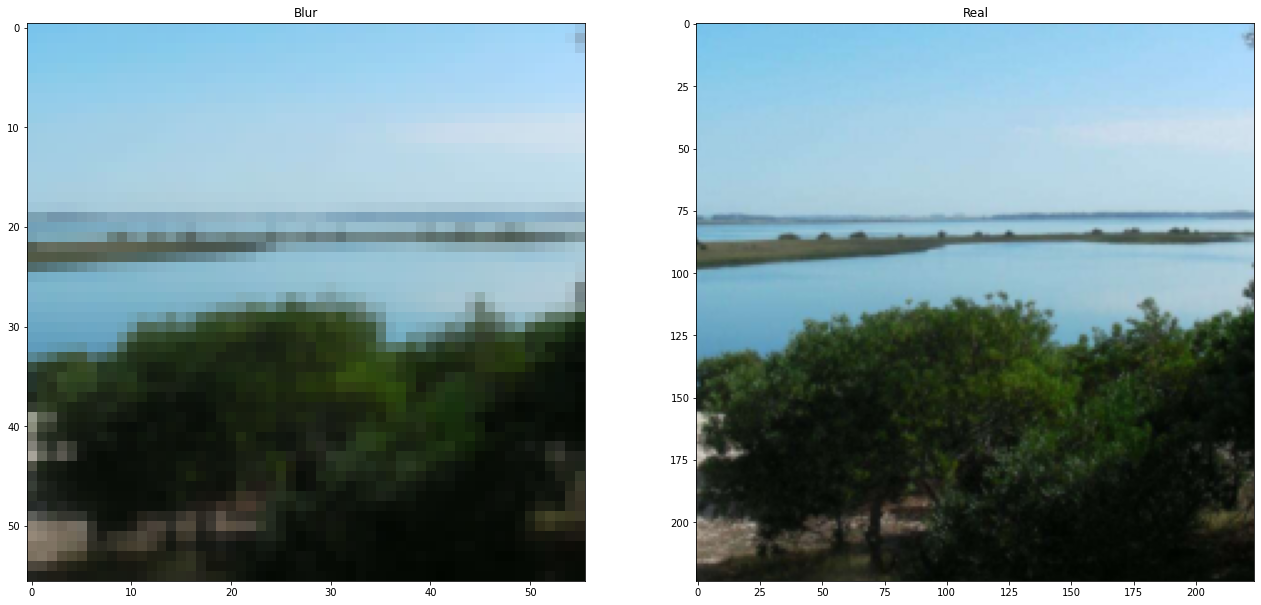

In [8]:
image, blur_image = val_dataset[1]
plt.figure(figsize=(22, 20))
plt.subplot(1, 2, 1)
plt.imshow(denormolize(blur_image.permute(1, 2, 0).numpy()))
plt.title('Blur')
plt.subplot(1, 2, 2)
plt.imshow(denormolize(image.permute(1, 2, 0).numpy()))
plt.title('Real')
plt.show()

### Generator

In [9]:
class ResidualBlock(nn.Module):
    def __init__(self, channels, kernel_size=3, stride=1, padding=0):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=channels,
                               out_channels=channels,
                               kernel_size=kernel_size,
                               stride=stride,
                               padding=padding)
        self.bn1 = nn.BatchNorm2d(num_features=channels)
        self.activ = nn.PReLU()
        self.conv2 = nn.Conv2d(in_channels=channels,
                               out_channels=channels,
                               kernel_size=kernel_size,
                               stride=stride,
                               padding=padding)
        self.bn2 = nn.BatchNorm2d(num_features=channels)
    
    def forward(self, in_features):
        x = self.conv1(in_features)
        x = self.bn1(x)
        x = self.activ(x)
        x = self.conv2(x)
        x = self.bn2(x)
        return x + in_features

In [10]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.in_layer = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=9, padding=4),
            nn.PReLU()
        )
        self.residual = nn.Sequential(
            ResidualBlock(channels=64, kernel_size=3, stride=1, padding=1),
            ResidualBlock(channels=64, kernel_size=3, stride=1, padding=1),
            ResidualBlock(channels=64, kernel_size=3, stride=1, padding=1),
            ResidualBlock(channels=64, kernel_size=3, stride=1, padding=1),
            ResidualBlock(channels=64, kernel_size=3, stride=1, padding=1)
        )
        self.last_residual = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=64)
        )
        self.conv_pixelx2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=256, kernel_size=3, padding=1),
            nn.PixelShuffle(2),
            nn.PReLU(),
            nn.Conv2d(in_channels=64, out_channels=256, kernel_size=3, padding=1),
            nn.PixelShuffle(2),
            nn.PReLU()
        )
        self.last_layers = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=3, kernel_size=9, padding=4),
            nn.Tanh()
        )
        
    def forward(self, x):
        res = self.in_layer(x)
        out_res = self.residual(res)
        out = self.last_residual(out_res + res)
        out = self.conv_pixelx2(out)
        out = self.last_layers(out)
        return out

In [11]:
generator = Generator().to(device)

### Discriminator

In [12]:
class ConvBNLReLU(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=0):
        super().__init__()
        self.conv = nn.Conv2d(in_channels=in_channels,
                              out_channels=out_channels,
                              kernel_size=kernel_size,
                              stride=stride,
                              padding=padding)
        self.bn = nn.BatchNorm2d(num_features=out_channels)
        self.activ = nn.LeakyReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.activ(x)
        return x

In [13]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.in_layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3), # 32 x 1022 x 718
            nn.LeakyReLU()
        )
        self.conv = nn.Sequential(
            ConvBNLReLU(in_channels=32, out_channels=64, kernel_size=3, stride=2), # 32 x 510 x 358
            ConvBNLReLU(in_channels=64, out_channels=96, kernel_size=3, stride=1), # 64 x 508 x 356
            ConvBNLReLU(in_channels=96, out_channels=96, kernel_size=3, stride=2), # 64 x 253 x 177
            ConvBNLReLU(in_channels=96, out_channels=144, kernel_size=3, stride=1), # 128 x 251 x 175
            ConvBNLReLU(in_channels=144, out_channels=144, kernel_size=3, stride=2), # 128 x 125 x 87
            ConvBNLReLU(in_channels=144, out_channels=216, kernel_size=3, stride=1), # 256 x 123 x 85
            ConvBNLReLU(in_channels=216, out_channels=216, kernel_size=3, stride=2), # 256 x 61 x 42
            ConvBNLReLU(in_channels=216, out_channels=328, kernel_size=3, stride=1), # 512 x 59 x 40
            ConvBNLReLU(in_channels=328, out_channels=328, kernel_size=3, stride=2), # 512 x 29 x 19
            ConvBNLReLU(in_channels=328, out_channels=488, kernel_size=3, stride=1), # 1024 x 27 x 17
            ConvBNLReLU(in_channels=488, out_channels=488, kernel_size=3, stride=2), # 1024 x 14 x 8
            ConvBNLReLU(in_channels=488, out_channels=512, kernel_size=3, stride=2), # 1024 x 6 x 3
            ConvBNLReLU(in_channels=512, out_channels=512, kernel_size=3, stride=2) # 1024 x 2 x 1
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512*2, 1000),
            nn.LeakyReLU(),
            nn.Linear(1000, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.in_layers(x)
        x = self.conv(x)
        x = self.fc(x)
        return x

In [14]:
discriminator = Discriminator().to(device)

In [15]:
discriminator = mobilenet_v2(pretrained=True)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


In [16]:
discriminator.classifier = nn.Sequential(
    nn.Dropout(p=0.1),
    nn.Linear(1280, 1),
    nn.Sigmoid()
)

In [17]:
discriminator = discriminator.to(device)

In [18]:
params = list(discriminator.parameters())

### Training

In [19]:
net = {
    'generator': generator,
    'discriminator': discriminator
}
lr = 0.0002
optimizer = {
    'generator': optim.Adam(generator.parameters(), lr=lr),
    'discriminator': optim.Adam(
        [
         {'lr':lr, 'params':params[130:]},
         {'lr':1e-5, 'params':params[:130]}
        ]
        )
}
criterion = {
    'bce': nn.BCELoss(),
    'mse': nn.MSELoss()
}

In [20]:
def train_one_epoch(net, loader, loss_fn, opt):
    avg_loss_g = 0
    avg_loss_d = 0
    avg_loss_mse = 0
    avg_loss_bce = 0
    net['generator'].train()
    net['discriminator'].train()

    for image, blur_image in tqdm(loader, leave=False):
        image, blur_image = image.to(device), blur_image.to(device)

        # discriminator
        opt['discriminator'].zero_grad()
        # real images
        label = torch.ones(image.size(0), device=device)
        output_d = net['discriminator'](image)
        real_loss = loss_fn['bce'](output_d.view(-1), label)
        avg_loss_d += real_loss.item()
        # fake images
        label = torch.zeros(image.size(0), device=device)
        with torch.no_grad():
            fake_image = net['generator'](blur_image)
        output_d = net['discriminator'](fake_image)
        fake_loss = loss_fn['bce'](output_d.view(-1), label)
        avg_loss_d += fake_loss.item()
        
        loss_d = fake_loss + real_loss
        loss_d.backward()
        opt['discriminator'].step()

        # generator
        opt['generator'].zero_grad()
        # mse loss
        generated_image = net['generator'](blur_image)
        loss_mse = loss_fn['mse'](generated_image, image)
        avg_loss_g += loss_mse.item()
        avg_loss_mse += loss_mse.item()
        # bce loss
        label = torch.ones(image.size(0), device=device)
        generated_image = net['generator'](blur_image)
        output_d = net['discriminator'](generated_image)
        loss_bce = loss_fn['bce'](output_d.view(-1), label)
        avg_loss_g += 1e-3 * loss_bce.item()
        avg_loss_bce += loss_bce.item()

        loss_g = loss_mse + 1e-3 * loss_bce
        loss_g.backward()
        opt['generator'].step()

    print(f'Train Discriminator Loss: {avg_loss_d:.4f}\tGenerator Loss: {avg_loss_g:.4f}\tBCE Loss: {avg_loss_bce:.4f}  MSE Loss: {avg_loss_mse:.4f}')
    return {
        'd':avg_loss_d,
        'g':avg_loss_g
        }

In [21]:
def evaluate_one_epoch(net, loader, loss_fn):
    avg_loss_g = 0
    avg_loss_d = 0
    avg_loss_mse = 0
    avg_loss_bce = 0
    net['generator'].eval()
    net['discriminator'].eval()

    with torch.no_grad():
        for image, blur_image in tqdm(loader, leave=False):
            image, blur_image = image.to(device), blur_image.to(device)

            # discriminator
            # real images
            label = torch.ones(image.size(0), device=device)
            output_d = net['discriminator'](image)
            real_loss = loss_fn['bce'](output_d.view(-1), label)
            avg_loss_d += real_loss.item()
            # fake images
            label = torch.zeros(image.size(0), device=device)
            fake_image = net['generator'](blur_image)
            output_d = net['discriminator'](fake_image)
            fake_loss = loss_fn['bce'](output_d.view(-1), label)
            avg_loss_d += fake_loss.item()

            # generator
            # mse loss
            generated_image = net['generator'](blur_image)
            loss_mse = loss_fn['mse'](generated_image, image)
            avg_loss_g += loss_mse.item()
            avg_loss_mse += loss_mse.item()
            # bce loss
            label = torch.ones(image.size(0), device=device)
            generated_image = net['generator'](blur_image)
            output_d = net['discriminator'](generated_image)
            loss_bce = loss_fn['bce'](output_d.view(-1), label)
            avg_loss_g += 1e-3 * loss_bce.item()
            avg_loss_bce += loss_bce.item()

    print(f'Val Discriminator Loss: {avg_loss_d:.4f}\tGenerator Loss: {avg_loss_g:.4f}\tBCE Loss: {avg_loss_bce:.4f}  MSE Loss: {avg_loss_mse:.4f}')
    return {
        'd':avg_loss_d,
        'g':avg_loss_g
        }    

In [43]:
def train_net(net, n_epoch, train_loader, val_loader, loss_fn, opt):
    min_val_loss = float('inf')
    for i in range(n_epoch):
        print(f'Epoch {i+1}/{n_epoch}')
        train_loss = train_one_epoch(net, train_loader, loss_fn, opt)
        val_loss = evaluate_one_epoch(net, val_loader, loss_fn)
        if val_loss['g'] < min_val_loss:
            min_val_loss = val_loss['g']
            torch.save(net['discriminator'].state_dict(), 'discriminator.pt')
            torch.save(net['generator'].state_dict(), 'generator.pt')

In [30]:
train_net(net, 20, train_loader, val_loader, criterion, optimizer)

Epoch 1/20


Train Discriminator Loss: 89.0579	Generator Loss: 6.8531	BCE Loss: 271.1550  MSE Loss: 6.5820


Val Discriminator Loss: 48.7188	Generator Loss: 0.8884	BCE Loss: 17.6937  MSE Loss: 0.8707
Epoch 2/20


Train Discriminator Loss: 5.3343	Generator Loss: 4.0997	BCE Loss: 640.7024  MSE Loss: 3.4590


Val Discriminator Loss: 56.7960	Generator Loss: 0.7576	BCE Loss: 27.1170  MSE Loss: 0.7305
Epoch 3/20


Train Discriminator Loss: 3.1491	Generator Loss: 3.8348	BCE Loss: 760.0385  MSE Loss: 3.0748


Val Discriminator Loss: 59.1965	Generator Loss: 0.6699	BCE Loss: 25.7860  MSE Loss: 0.6441
Epoch 4/20


Train Discriminator Loss: 1.0031	Generator Loss: 3.6347	BCE Loss: 846.1913  MSE Loss: 2.7885


Val Discriminator Loss: 57.0732	Generator Loss: 0.6082	BCE Loss: 43.8823  MSE Loss: 0.5643
Epoch 5/20


Train Discriminator Loss: 3.5749	Generator Loss: 3.4658	BCE Loss: 830.3633  MSE Loss: 2.6354


Val Discriminator Loss: 42.0902	Generator Loss: 0.6566	BCE Loss: 24.9457  MSE Loss: 0.6316
Epoch 6/20


Train Discriminator Loss: 0.5235	Generator Loss: 3.5680	BCE Loss: 944.8405  MSE Loss: 2.6231


Val Discriminator Loss: 46.8818	Generator Loss: 0.5659	BCE Loss: 24.6894  MSE Loss: 0.5412
Epoch 7/20


Train Discriminator Loss: 4.9804	Generator Loss: 3.3367	BCE Loss: 919.5682  MSE Loss: 2.4172


Val Discriminator Loss: 44.3686	Generator Loss: 0.5773	BCE Loss: 44.8462  MSE Loss: 0.5325
Epoch 8/20


Train Discriminator Loss: 0.7418	Generator Loss: 3.2700	BCE Loss: 908.4426  MSE Loss: 2.3615


Val Discriminator Loss: 52.9445	Generator Loss: 0.5497	BCE Loss: 47.7128  MSE Loss: 0.5020
Epoch 9/20


Train Discriminator Loss: 0.5038	Generator Loss: 3.2537	BCE Loss: 1002.4680  MSE Loss: 2.2512


Val Discriminator Loss: 66.0692	Generator Loss: 0.6202	BCE Loss: 63.7658  MSE Loss: 0.5564
Epoch 10/20


Train Discriminator Loss: 14.7200	Generator Loss: 3.2083	BCE Loss: 921.9642  MSE Loss: 2.2864


Val Discriminator Loss: 43.6136	Generator Loss: 0.5881	BCE Loss: 27.3651  MSE Loss: 0.5607
Epoch 11/20


Train Discriminator Loss: 0.4086	Generator Loss: 3.1936	BCE Loss: 979.5299  MSE Loss: 2.2141


Val Discriminator Loss: 45.3791	Generator Loss: 0.5112	BCE Loss: 30.4418  MSE Loss: 0.4807
Epoch 12/20


Train Discriminator Loss: 3.8222	Generator Loss: 3.2328	BCE Loss: 994.5912  MSE Loss: 2.2382


Val Discriminator Loss: 42.4007	Generator Loss: 0.5852	BCE Loss: 28.2515  MSE Loss: 0.5570
Epoch 13/20


Train Discriminator Loss: 0.3226	Generator Loss: 3.3055	BCE Loss: 1030.6705  MSE Loss: 2.2749


Val Discriminator Loss: 49.6952	Generator Loss: 0.5508	BCE Loss: 60.8843  MSE Loss: 0.4899
Epoch 14/20


Train Discriminator Loss: 0.2526	Generator Loss: 3.1567	BCE Loss: 1094.7194  MSE Loss: 2.0620


Val Discriminator Loss: 42.1533	Generator Loss: 0.5049	BCE Loss: 34.4648  MSE Loss: 0.4704
Epoch 15/20


Train Discriminator Loss: 0.2201	Generator Loss: 3.1894	BCE Loss: 1088.8320  MSE Loss: 2.1006


Val Discriminator Loss: 45.9604	Generator Loss: 0.5614	BCE Loss: 42.1905  MSE Loss: 0.5192
Epoch 16/20


Train Discriminator Loss: 1.2857	Generator Loss: 3.2655	BCE Loss: 1129.4254  MSE Loss: 2.1361


Val Discriminator Loss: 88.3927	Generator Loss: 0.5696	BCE Loss: 93.7335  MSE Loss: 0.4759
Epoch 17/20


Train Discriminator Loss: 3.3126	Generator Loss: 3.2704	BCE Loss: 1113.2024  MSE Loss: 2.1572


Val Discriminator Loss: 50.6506	Generator Loss: 0.6319	BCE Loss: 64.6845  MSE Loss: 0.5672
Epoch 18/20


Train Discriminator Loss: 0.1717	Generator Loss: 3.5333	BCE Loss: 1306.7431  MSE Loss: 2.2265


Val Discriminator Loss: 55.2502	Generator Loss: 0.5126	BCE Loss: 60.4390  MSE Loss: 0.4522
Epoch 19/20


Train Discriminator Loss: 0.0951	Generator Loss: 3.3934	BCE Loss: 1294.4310  MSE Loss: 2.0989


Val Discriminator Loss: 54.1770	Generator Loss: 0.6090	BCE Loss: 54.1877  MSE Loss: 0.5548
Epoch 20/20


Train Discriminator Loss: 0.0765	Generator Loss: 3.4330	BCE Loss: 1309.2471  MSE Loss: 2.1238


Val Discriminator Loss: 49.9154	Generator Loss: 0.4904	BCE Loss: 56.1891  MSE Loss: 0.4342


In [23]:
net['generator'].load_state_dict(torch.load('.//generator.pt'))
net['discriminator'].load_state_dict(torch.load('.//discriminator.pt'))

<All keys matched successfully>

In [25]:
image, b_image = train_dataset[1]
b_image = b_image.unsqueeze(0).to(device)

In [26]:
with torch.no_grad():
    super_image = net['generator'](b_image)

In [27]:
super_image = super_image.cpu()
b_image = b_image.cpu()

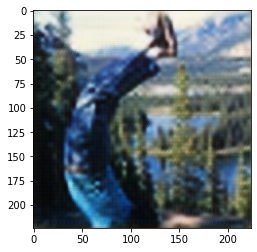

In [28]:
plt.imshow(denormolize(super_image.squeeze(0).permute(1, 2, 0).numpy()))
plt.show()

In [39]:
cv2.imwrite('./result.png', cv2.cvtColor(denormolize(super_image.squeeze(0).permute(1, 2, 0).numpy()) * 255, cv2.COLOR_RGB2BGR))
img = Image.open('./result.png')
img1 = tt.Resize(180)(img)
img1.save('small_result.png')

True

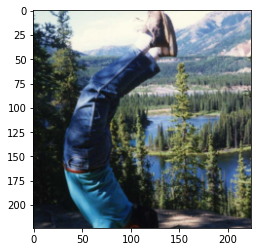

In [29]:
plt.imshow(denormolize(image.permute(1, 2, 0).numpy()))
plt.show()

In [ ]:
cv2.imwrite('./ground_true.png', denormolize(image.permute(1, 2, 0).numpy()) * 255)

True

True

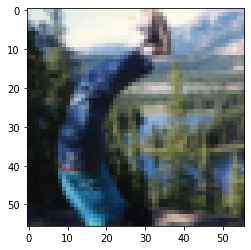

In [30]:
plt.imshow(denormolize(b_image.squeeze(0).permute(1, 2, 0).numpy()))
plt.show()

In [ ]:
cv2.imwrite('./blur.png', denormolize(b_image.squeeze(0).permute(1, 2, 0).numpy()) * 255)

True

In [44]:
lr = 5e-5
optimizer = {
    'generator': optim.Adam(generator.parameters(), lr=lr),
    'discriminator': optim.Adam(
        [
         {'lr':lr, 'params':params[130:]},
         {'lr':1e-5, 'params':params[:130]}
        ]
        )
}

In [45]:
train_net(net, 10, train_loader, val_loader, criterion, optimizer)

Epoch 1/10


Train Discriminator Loss: 0.3481	Generator Loss: 3.1423	BCE Loss: 1222.7354  MSE Loss: 1.9196


Val Discriminator Loss: 52.1657	Generator Loss: 0.4918	BCE Loss: 34.7572  MSE Loss: 0.4570
Epoch 2/10


Train Discriminator Loss: 1.8672	Generator Loss: 3.2401	BCE Loss: 1337.2875  MSE Loss: 1.9028


Val Discriminator Loss: 101.9037	Generator Loss: 0.5427	BCE Loss: 106.4309  MSE Loss: 0.4362
Epoch 3/10


Train Discriminator Loss: 0.1344	Generator Loss: 3.1462	BCE Loss: 1337.6190  MSE Loss: 1.8086


Val Discriminator Loss: 68.6380	Generator Loss: 0.4831	BCE Loss: 65.7200  MSE Loss: 0.4174
Epoch 4/10


Train Discriminator Loss: 0.0527	Generator Loss: 3.1119	BCE Loss: 1305.9764  MSE Loss: 1.8060


Val Discriminator Loss: 64.9749	Generator Loss: 0.4796	BCE Loss: 55.4676  MSE Loss: 0.4241
Epoch 5/10


Train Discriminator Loss: 2.9626	Generator Loss: 3.1146	BCE Loss: 1276.0113  MSE Loss: 1.8386


Val Discriminator Loss: 78.3653	Generator Loss: 0.4891	BCE Loss: 73.7090  MSE Loss: 0.4154
Epoch 6/10


Train Discriminator Loss: 0.1070	Generator Loss: 3.0960	BCE Loss: 1287.0068  MSE Loss: 1.8090


Val Discriminator Loss: 82.0475	Generator Loss: 0.4954	BCE Loss: 74.2475  MSE Loss: 0.4212
Epoch 7/10


Train Discriminator Loss: 0.4499	Generator Loss: 3.0428	BCE Loss: 1273.2196  MSE Loss: 1.7696


Val Discriminator Loss: 106.7363	Generator Loss: 0.5286	BCE Loss: 116.8991  MSE Loss: 0.4117
Epoch 8/10


Train Discriminator Loss: 0.1542	Generator Loss: 3.0388	BCE Loss: 1267.9274  MSE Loss: 1.7709


Val Discriminator Loss: 85.0683	Generator Loss: 0.5039	BCE Loss: 91.3616  MSE Loss: 0.4125
Epoch 9/10


Train Discriminator Loss: 0.0770	Generator Loss: 3.0309	BCE Loss: 1280.2156  MSE Loss: 1.7507


Val Discriminator Loss: 79.1573	Generator Loss: 0.4818	BCE Loss: 75.9908  MSE Loss: 0.4058
Epoch 10/10


Train Discriminator Loss: 0.1772	Generator Loss: 3.0337	BCE Loss: 1276.0747  MSE Loss: 1.7576


Val Discriminator Loss: 69.9880	Generator Loss: 0.4753	BCE Loss: 57.0589  MSE Loss: 0.4182


In [46]:
net['generator'].load_state_dict(torch.load('.//generator.pt'))
net['discriminator'].load_state_dict(torch.load('.//discriminator.pt'))

<All keys matched successfully>

In [47]:
image, b_image = train_dataset[1]
b_image = b_image.unsqueeze(0).to(device)

In [48]:
with torch.no_grad():
    super_image = net['generator'](b_image)

In [49]:
super_image = super_image.cpu()
b_image = b_image.cpu()

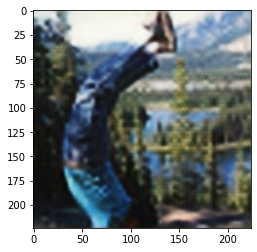

In [50]:
plt.imshow(denormolize(super_image.squeeze(0).permute(1, 2, 0).numpy()))
plt.show()

In [59]:
cv2.imwrite('./result.png', cv2.cvtColor(denormolize(super_image.squeeze(0).permute(1, 2, 0).numpy()) * 255, cv2.COLOR_RGB2BGR))
img = Image.open('./result.png')
img1 = tt.Resize(112)(img)
img1.save('small_result.png')

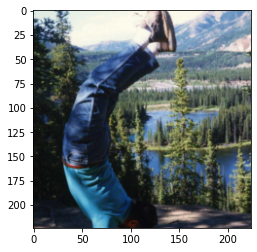

In [52]:
plt.imshow(denormolize(image.permute(1, 2, 0).numpy()))
plt.show()

In [53]:
cv2.imwrite('./ground_true.png', denormolize(image.permute(1, 2, 0).numpy()) * 255)

True

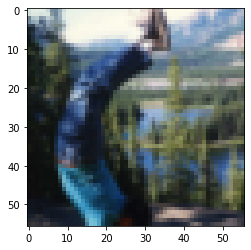

In [54]:
plt.imshow(denormolize(b_image.squeeze(0).permute(1, 2, 0).numpy()))
plt.show()

In [56]:
cv2.imwrite('./blur.png', denormolize(b_image.squeeze(0).permute(1, 2, 0).numpy()) * 255)

True

In [60]:
input_transform = tt.Compose(
    [
     tt.ToTensor(),
     tt.Normalize(0.5, 0.5)
    ]
)

In [61]:
img = input_transform(Image.open('input.png'))

In [93]:
with torch.no_grad():
    result = nn.MaxPool2d(kernel_size=4, stride=4)(img.unsqueeze(0))

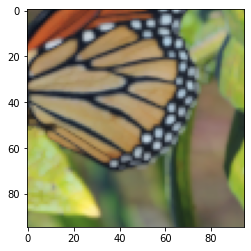

In [94]:
plt.imshow(denormolize(result.squeeze(0).permute(1, 2, 0).numpy()))
plt.show()

In [64]:
with torch.no_grad():
    output = net['generator'](img.unsqueeze(0).to(device)).squeeze(0).cpu()

In [73]:
_, w, h = output.shape
resized_image = cv2.resize(denormolize(output.permute(1, 2, 0).numpy()), (int(w*0.25), int(h*0.25)))

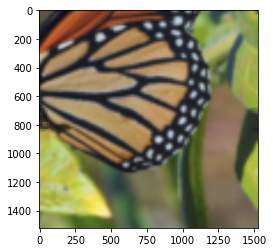

In [85]:
plt.imshow(denormolize(output.permute(1, 2, 0).numpy()))
plt.show()

In [86]:
cv2.imwrite('./example.png', cv2.cvtColor((denormolize(output.permute(1, 2, 0).numpy()) * 255), cv2.COLOR_RGB2BGR))

True